# Imports

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

pd.set_option('display.max_columns', 40)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler

from collections import OrderedDict

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

import feather
import os
import time

from IPython.display import display

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
!ls 'data'

sample_submission.csv  X_test.csv      X_train.csv	y_train.csv
train.csv	       X_test.csv.zip  X_train.csv.zip


In [3]:
train_values = pd.read_csv('data/X_train.csv', index_col=0)
train_labels = pd.read_csv('data/y_train.csv', index_col=0) 
test_values = pd.read_csv('data/X_test.csv', index_col=0)

# EDA

In [4]:
train_values.head(1)

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
row_id,,,,,,,,,,,,
0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.10765,0.017561,0.000767,-0.74857,2.103,-9.7532


In [5]:
test_values.head(1)

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
row_id,,,,,,,,,,,,
0_0,0,0,-0.025773,-0.98864,-0.14801,0.00335,-0.006524,-0.001071,-0.02739,0.10043,4.2061,-5.5439


In [6]:
train_labels.head(1)

,group_id,surface
series_id,,
0,13,fine_concrete


In [7]:
train_values.dtypes

series_id                  int64
measurement_number         int64
orientation_X            float64
orientation_Y            float64
orientation_Z            float64
orientation_W            float64
angular_velocity_X       float64
angular_velocity_Y       float64
angular_velocity_Z       float64
linear_acceleration_X    float64
linear_acceleration_Y    float64
linear_acceleration_Z    float64
dtype: object

In [8]:
test_values.dtypes

series_id                  int64
measurement_number         int64
orientation_X            float64
orientation_Y            float64
orientation_Z            float64
orientation_W            float64
angular_velocity_X       float64
angular_velocity_Y       float64
angular_velocity_Z       float64
linear_acceleration_X    float64
linear_acceleration_Y    float64
linear_acceleration_Z    float64
dtype: object

In [9]:
train_labels.dtypes

group_id     int64
surface     object
dtype: object

In [10]:
train_values.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


Conclusion: The training set contains 3810 series, and each series has 128 observations

In [11]:
test_values.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000
mean,1907.500000,63.500000,0.031996,0.120651,0.018735,0.004024,0.000401,0.013669,-0.036101,0.125433,2.906588,-9.359811
std,1101.585403,36.949327,0.671977,0.714522,0.108481,0.100957,0.114485,0.089440,0.233791,1.832639,2.094727,2.802670
min,0.000000,0.000000,-0.989720,-0.989810,-0.154680,-0.156270,-2.403300,-1.193000,-1.458200,-35.040000,-107.480000,-83.173000
25%,953.750000,31.750000,-0.648130,-0.744503,-0.112660,-0.098435,-0.037396,-0.029865,-0.089842,-0.486233,2.052100,-10.125000
50%,1907.500000,63.500000,0.132910,0.397860,0.057271,0.022654,0.001107,0.007276,-0.008911,0.112490,2.900300,-9.361700
75%,2861.250000,95.250000,0.575270,0.803600,0.124770,0.083706,0.037827,0.051112,0.057876,0.727250,3.758000,-8.582075
max,3815.000000,127.000000,0.989320,0.988940,0.154250,0.152510,3.396600,1.150700,0.960280,36.628000,55.624000,59.633000


Conclusion: The test set contains 3815 series, each with 128 observations

At a glance, the values in the train and test sets do not appear hugely different - although it's difficult to say

What I can glean is that the variance in linear_acceleration is an order of magnitude larger than in the other categories 

In addition, the maximum and minimums for linear_acceleration_Y and linear_acceleration_Z are much much larger than in any other category

## Nans

In [12]:
def null_count(df):
    df_missing = df.isnull()
    for column in df_missing.columns.values:
        print(column)
        print(df_missing[column].value_counts())
        print("")

In [13]:
null_count(train_values)

series_id
False    487680
Name: series_id, dtype: int64

measurement_number
False    487680
Name: measurement_number, dtype: int64

orientation_X
False    487680
Name: orientation_X, dtype: int64

orientation_Y
False    487680
Name: orientation_Y, dtype: int64

orientation_Z
False    487680
Name: orientation_Z, dtype: int64

orientation_W
False    487680
Name: orientation_W, dtype: int64

angular_velocity_X
False    487680
Name: angular_velocity_X, dtype: int64

angular_velocity_Y
False    487680
Name: angular_velocity_Y, dtype: int64

angular_velocity_Z
False    487680
Name: angular_velocity_Z, dtype: int64

linear_acceleration_X
False    487680
Name: linear_acceleration_X, dtype: int64

linear_acceleration_Y
False    487680
Name: linear_acceleration_Y, dtype: int64

linear_acceleration_Z
False    487680
Name: linear_acceleration_Z, dtype: int64



In [14]:
null_count(test_values)

series_id
False    488448
Name: series_id, dtype: int64

measurement_number
False    488448
Name: measurement_number, dtype: int64

orientation_X
False    488448
Name: orientation_X, dtype: int64

orientation_Y
False    488448
Name: orientation_Y, dtype: int64

orientation_Z
False    488448
Name: orientation_Z, dtype: int64

orientation_W
False    488448
Name: orientation_W, dtype: int64

angular_velocity_X
False    488448
Name: angular_velocity_X, dtype: int64

angular_velocity_Y
False    488448
Name: angular_velocity_Y, dtype: int64

angular_velocity_Z
False    488448
Name: angular_velocity_Z, dtype: int64

linear_acceleration_X
False    488448
Name: linear_acceleration_X, dtype: int64

linear_acceleration_Y
False    488448
Name: linear_acceleration_Y, dtype: int64

linear_acceleration_Z
False    488448
Name: linear_acceleration_Z, dtype: int64



In [15]:
null_count(train_labels)

group_id
False    3810
Name: group_id, dtype: int64

surface
False    3810
Name: surface, dtype: int64



Conclusion: No null values in any of the DataFrames

## Correlations

In [16]:
train_corr = train_values.corr()

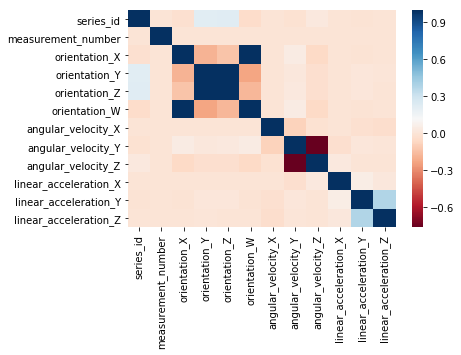

In [17]:
sns.heatmap(train_corr,
           xticklabels=train_corr.columns,
           yticklabels=train_corr.columns,
           cmap = 'RdBu')

Conclusions:  
-orientation_X and orientation_W are completely correlated  
-other orientations have slight negative correlation  
-Uncertain correlations between angular_velocity_Z and all the orientations
-angular_velocity_Y and angular_velocity_Z are strongly negatively correlated  
-linear_acceleration_Y and linear_acceleration_Z are slightly correlations

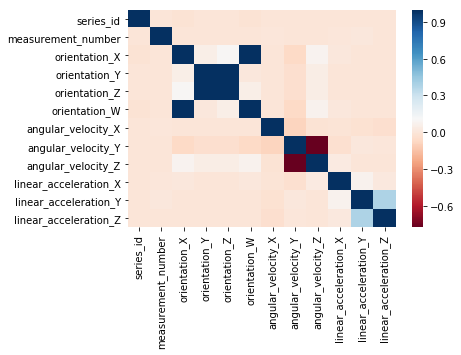

In [18]:
test_corr = test_values.corr()
sns.heatmap(test_corr,
           xticklabels=test_corr.columns,
           yticklabels=test_corr.columns,
           cmap='RdBu')

Conclusions:  
-very similar to the train_set  
-only major differnce is reduced correlation between orientation_X and orientation_Y/orientation_Z  
-And perhaps angular_velocity_Y is now negatively correlated with Orientations

## Label Distribution

In [19]:
train_labels.describe(include=object)

,surface
count,3810
unique,9
top,concrete
freq,779


In [20]:
train_labels.head(5)

,group_id,surface
series_id,,
0,13,fine_concrete
1,31,concrete
2,20,concrete
3,31,concrete
4,22,soft_tiles


In [21]:
train_labels['surface'].value_counts()

concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64

In [25]:
train_labels['surface'].value_counts()/train_labels['surface'].value_counts().sum()

concrete                  0.204462
soft_pvc                  0.192126
wood                      0.159318
tiled                     0.134908
fine_concrete             0.095276
hard_tiles_large_space    0.080840
soft_tiles                0.077953
carpet                    0.049606
hard_tiles                0.005512
Name: surface, dtype: float64

Conclusion - Concrete is the most popular, although soft_pvc is close behind - hard_tiles are exceptionally uncommon

## Concatenate Data

Concatenated X_train and y_train to see if there's some underlying patterns in the groups

In [32]:
column_names = ['row_id', 'series_id', 'measurement_number', 'orientation_X',
       'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z', 'series_id', 'group_id', 'surface']

In [35]:
full_train = pd.read_csv('data/train.csv',names=column_names,index_col=0)

In [36]:
full_train.head(1)

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id.1,group_id,surface
row_id,,,,,,,,,,,,,,,
0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.10765,0.017561,0.000767,-0.74857,2.103,-9.7532,0,13,fine_concrete


### Visualization

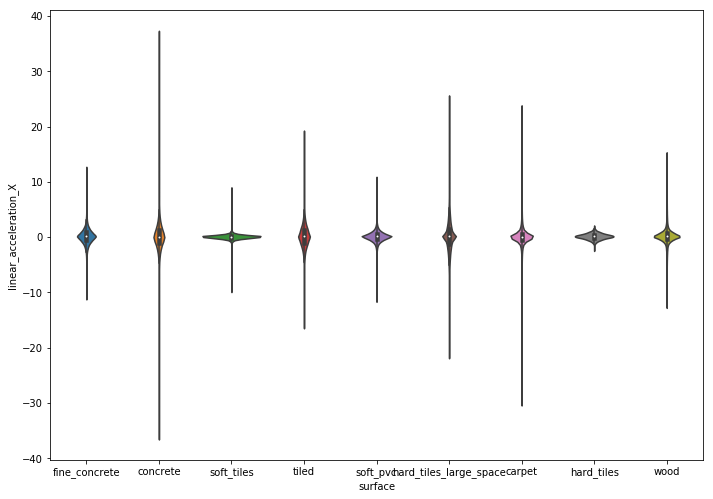

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.violinplot(x='surface', y='linear_acceleration_X', data=full_train)

Only grab the columns that provide useful information

In [ ]:
indep_columns = full_train.columns.values[2:-3]

In [50]:
print(indep_columns)

['orientation_X' 'orientation_Y' 'orientation_Z' 'orientation_W'
 'angular_velocity_X' 'angular_velocity_Y' 'angular_velocity_Z'
 'linear_acceleration_X' 'linear_acceleration_Y' 'linear_acceleration_Z']


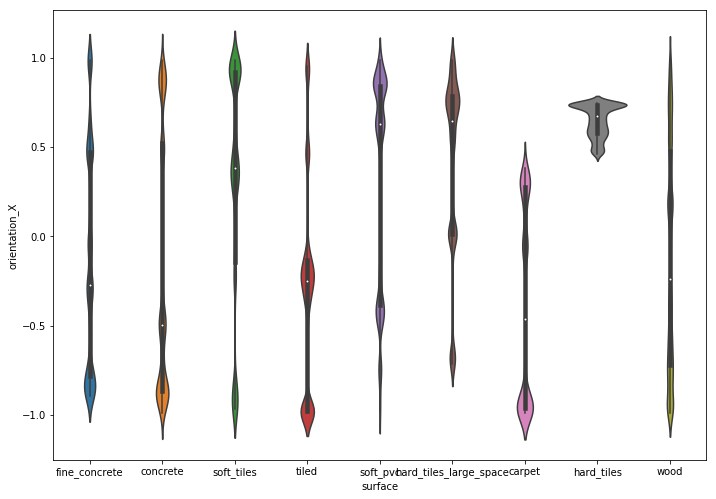

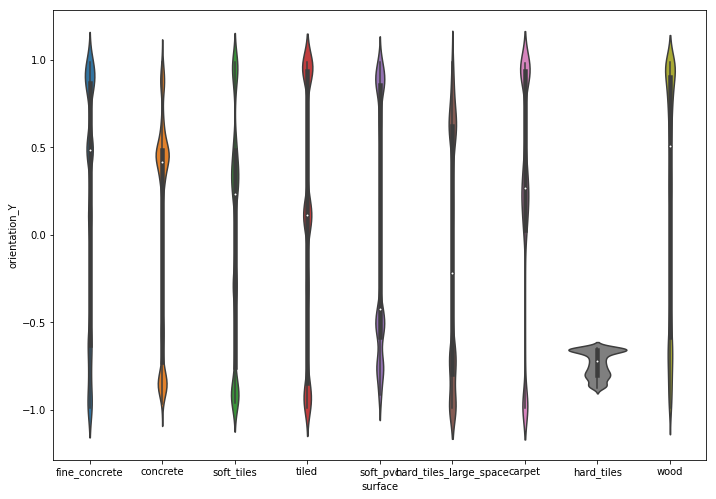

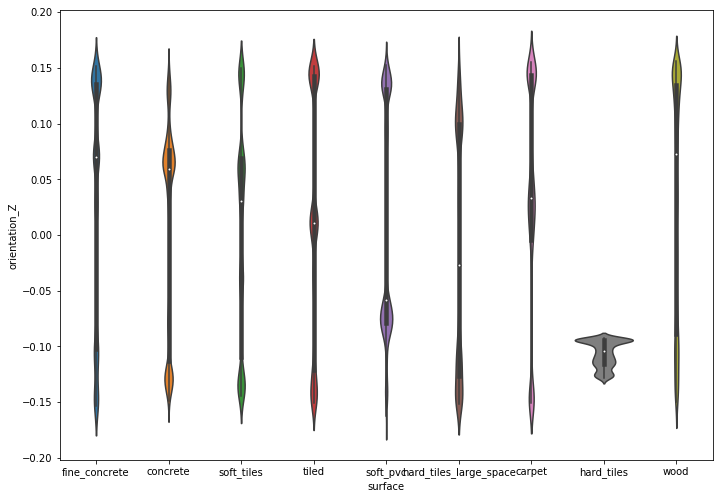

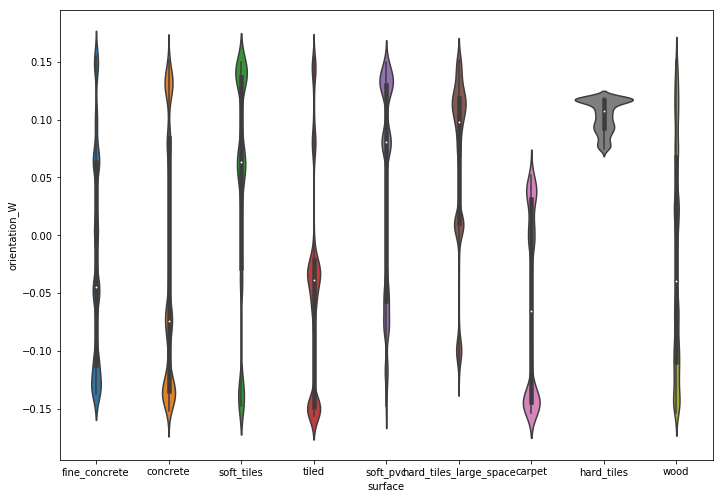

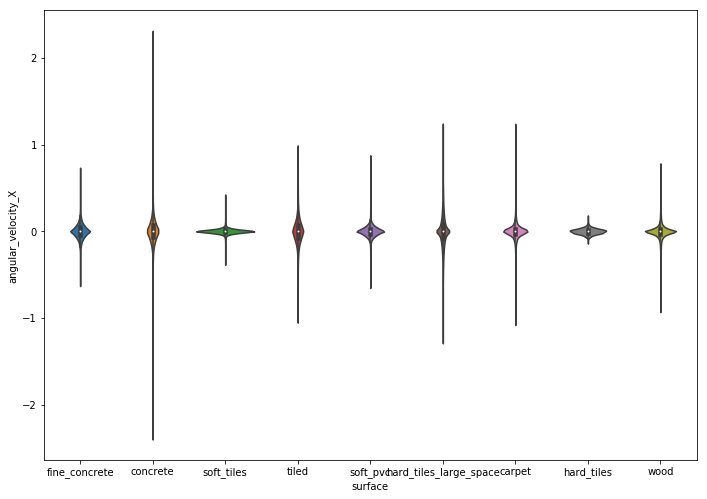

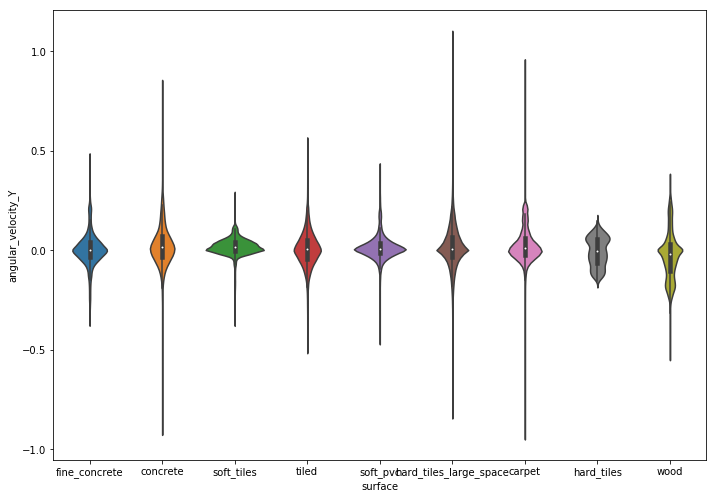

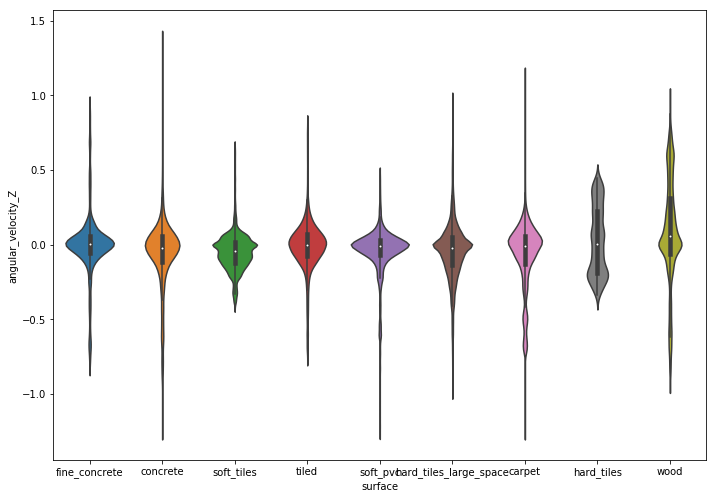

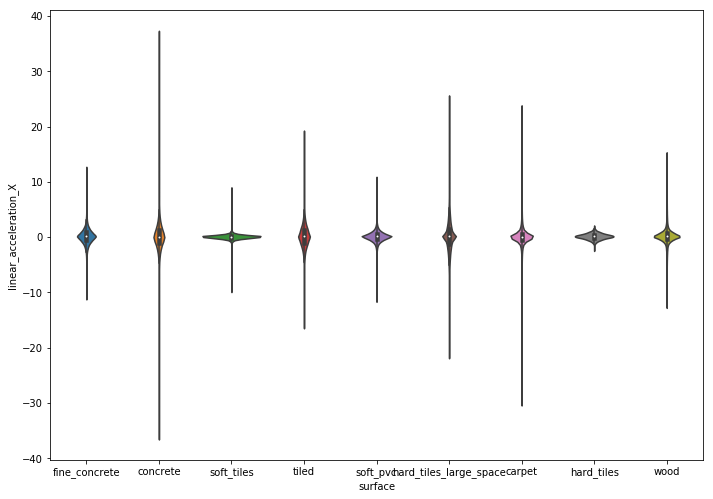

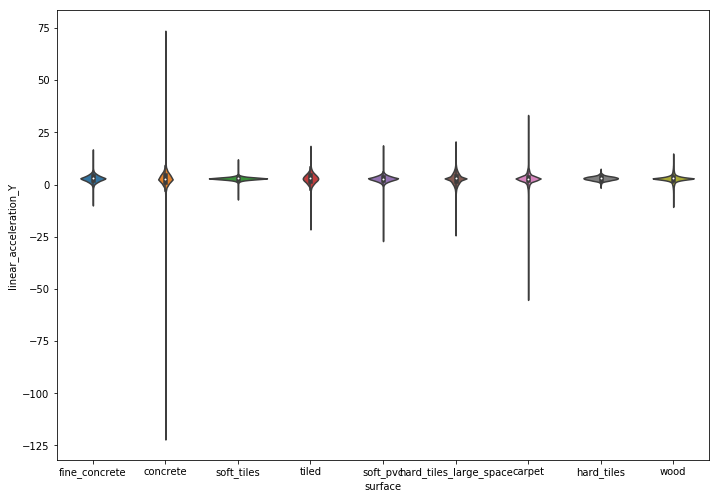

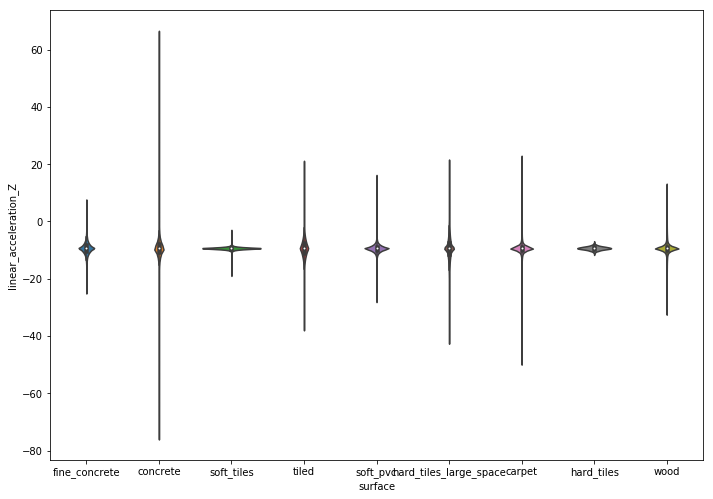

In [52]:
for column in indep_columns:
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.violinplot(x='surface', y=column, data=full_train)

### Group by Orientation

#### Table

In [53]:
full_train.columns

Index(['series_id', 'measurement_number', 'orientation_X', 'orientation_Y',
       'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z', 'series_id.1',
       'group_id', 'surface'],
      dtype='object')

In [56]:
gptest = full_train[['orientation_X','orientation_Y','surface']]
grouped_test1 = gptest.groupby(['surface'],as_index=False).mean()

In [57]:
grouped_test1

,surface,orientation_X,orientation_Y
0,carpet,-0.385794,0.232877
1,concrete,-0.207607,0.078932
2,fine_concrete,-0.143290,0.188151
3,hard_tiles,0.650556,-0.735114
4,hard_tiles_large_space,0.393165,-0.113644
5,soft_pvc,0.309570,-0.011457
6,soft_tiles,0.276689,0.017786
7,tiled,-0.275754,0.075003
8,wood,-0.138246,0.209518


#### ANOVA

In [76]:
gptest['surface'].unique()

array(['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood'],
      dtype=object)

In [66]:
gptest.head(3)

,orientation_X,orientation_Y,surface
row_id,,,
0_0,-0.75853,-0.63435,fine_concrete
0_1,-0.75853,-0.63434,fine_concrete
0_2,-0.75853,-0.63435,fine_concrete


In [69]:
grouped_test2 = gptest.groupby(['surface'],as_index=False)

In [75]:
grouped_test2.get_group('fine_concrete')['orientation_X'].head(3)

row_id
0_0   -0.75853
0_1   -0.75853
0_2   -0.75853
Name: orientation_X, dtype: float64

In [82]:
f_val, p_val = stats.f_oneway(grouped_test2.get_group('fine_concrete')['orientation_X'], grouped_test2.get_group('concrete')['orientation_X'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 270.896731231844 , P = 8.209449495074757e-61


In [128]:
def ANOVA(data, cat1, cat2, var):
    f_val, p_val = stats.f_oneway(data.get_group(cat1)[var], grouped_test2.get_group(cat2)[var])
    print( "ANOVA for {0} and {1} on {2}: F = {3:.3f}, P = {4}".format(cat1, cat2, var, f_val, p_val))

In [129]:
ANOVA(grouped_test2, 'fine_concrete', 'concrete', 'orientation_X')

ANOVA for fine_concrete and concrete on orientation_X: F = 270.897, P = 8.209449495074757e-61


In [130]:
surface_types = full_train['surface'].unique()

In [136]:
for surface in surface_types:
    ANOVA(grouped_test2, 'fine_concrete', surface, 'orientation_X')
    print('\n')

ANOVA for fine_concrete and fine_concrete on orientation_X: F = 0.000, P = 1.0


ANOVA for fine_concrete and concrete on orientation_X: F = 270.897, P = 8.209449495074757e-61


ANOVA for fine_concrete and soft_tiles on orientation_X: F = 8797.854, P = 0.0


ANOVA for fine_concrete and tiled on orientation_X: F = 1300.595, P = 3.5473900824199744e-283


ANOVA for fine_concrete and soft_pvc on orientation_X: F = 16693.650, P = 0.0


ANOVA for fine_concrete and hard_tiles_large_space on orientation_X: F = 18090.927, P = 0.0


ANOVA for fine_concrete and carpet on orientation_X: F = 2552.888, P = 0.0


ANOVA for fine_concrete and hard_tiles on orientation_X: F = 4282.002, P = 0.0


ANOVA for fine_concrete and wood on orientation_X: F = 1.867, P = 0.17184977381570515




In [140]:
print(scaler.fit(train_values))

StandardScaler(copy=True, with_mean=True, with_std=True)


In [143]:
print(scaler.transform(train_values))

[[-1.73159626 -1.71857161 -1.07989683 ... -0.46928895 -0.36609528
  -0.13647385]
 [-1.73159626 -1.69150749 -1.07989683 ...  0.11262123 -0.64487185
  -0.01683956]
 [-1.73159626 -1.66444337 -1.07989683 ... -0.21039847 -0.60477961
   0.2242917 ]
 ...
 [ 1.73159626  1.66444337  0.94350897 ...  1.37684263  0.64284601
   0.42897738]
 [ 1.73159626  1.69150749  0.94368397 ...  1.28927705  0.85349381
  -0.02762914]
 [ 1.73159626  1.71857161  0.94385898 ...  0.37134063  0.64887386
  -0.39823535]]


# Feature Engineering

In [4]:
ts_cols = train_values.columns

In [5]:
ts_cols

Index(['series_id', 'measurement_number', 'orientation_X', 'orientation_Y',
       'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z'],
      dtype='object')

In [6]:
def prep_time_series_features(df, columns=None):
    if columns is None:
        columns = df.columns
    
    ts_df = df[ts_cols].set_index('series_id')
    
    ts_features = ts_df.groupby('series_id').agg(['min', 'max', 'mean', 'std', lambda x: x.tail(10).mean()])
    
    return ts_features

In [7]:
train_features = prep_time_series_features(train_values)

# Model Creation

## Sanity Check

In [8]:
y = np.ravel(train_labels['surface'])

In [9]:
%%time
rf = RandomForestClassifier(n_estimators=10, random_state=2019)
rf.fit(train_features, y)

CPU times: user 204 ms, sys: 0 ns, total: 204 ms
Wall time: 200 ms


In [10]:
rf.score(train_features, y)

0.9973753280839895

## Train-Test Split

In [11]:
valid_size = int(len(train_features) * 0.1)

In [12]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = valid_size
n_trn = len(train_features)-n_valid
raw_train, raw_valid = split_vals(train_features, n_trn)
X_train, X_valid = split_vals(train_features, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((3429, 55), (3429,), (381, 55))

In [13]:
train_labels['surface'].unique()

array(['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood'],
      dtype=object)

### Metrics

In [14]:
def print_score(m):
    p, r, f1, s = precision_recall_fscore_support(y_valid, m.predict(X_valid), average='weighted')
    print("The Weighted F1 Score is: {}".format(f1))
    print("The Precision Score is: {}".format(p))
    print("The Recall Score is: {}".format(r))
    print("\n")
    
    target_names = train_labels['surface'].unique()
    print("                       Test Set Results")
    print(classification_report(y_valid, m.predict(X_valid), target_names=target_names))

### Sanity Check 2

In [15]:
m = RandomForestClassifier(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 272 ms, sys: 4 ms, total: 276 ms
Wall time: 115 ms
The Weighted F1 Score is: 0.8193725952720126
The Precision Score is: 0.8291453007160876
The Recall Score is: 0.8136482939632546


                       Test Set Results
                        precision    recall  f1-score   support

         fine_concrete       0.72      0.87      0.79        15
              concrete       0.85      0.86      0.86        88
            soft_tiles       0.73      0.56      0.63        43
                 tiled       0.00      0.00      0.00         0
              soft_pvc       0.90      0.90      0.90        41
hard_tiles_large_space       0.84      0.84      0.84        58
                carpet       0.00      0.00      0.00         0
            hard_tiles       0.90      0.82      0.86        68
                  wood       0.75      0.81      0.78        68

           avg / total       0.83      0.81      0.82       381



# Parameter Tuning

## Manual

In [16]:
RANDOM_STATE=2019

In [21]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
]

In [ ]:
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))


In [22]:
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

In [23]:
min_estimators = 15
max_estimators = 300

In [25]:
for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(train_features, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

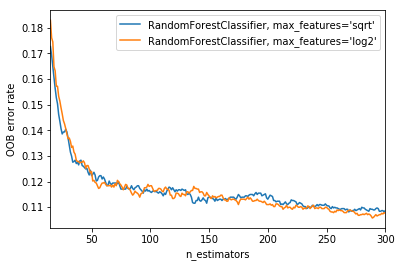

In [26]:
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

Seems like the optimal number of estimators is ~300, with max_features at 'log2'

## min_samples_leaf

In [27]:
m = RandomForestClassifier(n_estimators=275,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               min_samples_leaf=3,
                               random_state=RANDOM_STATE)
m.fit(train_features, y)
print("oob_error :{}".format(1 - m.oob_score_))

oob_error :0.1286089238845144


Oooooorrrr not

## Grid Search

In [34]:
baseRF = RandomForestClassifier(n_estimators = 275, 
                               random_state = 2019,
                               n_jobs = -1,
                               oob_score = True)

In [35]:
param_grid = {
    'min_samples_leaf' :[1,3,5], 
    'max_features' : ['log2', 'sqrt'],
    'criterion' : ['gini','entropy']
}

In [36]:
from sklearn.model_selection import GridSearchCV
cvRF = GridSearchCV(estimator=baseRF, param_grid=param_grid, scoring='f1_weighted')
cvRF.fit(train_features,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=275, n_jobs=-1,
            oob_score=True, random_state=2019, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 3, 5], 'max_features': ['log2', 'sqrt'], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [37]:
cvRF.best_params_

{'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 1}

In [38]:
cvRF.best_score_

0.7122507535733885

# Model Evaluation

In [43]:
model = RandomForestClassifier(n_estimators = 275, 
                               random_state = 2019,
                               n_jobs = -1,
                               oob_score = True,
                               criterion = 'gini',
                               min_samples_leaf = 1,
                               max_features='log2')
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=275, n_jobs=-1,
            oob_score=True, random_state=2019, verbose=0, warm_start=False)

In [44]:
model.oob_score_

0.8856809565470983

In [46]:
print_score(model)

The Weighted F1 Score is: 0.8698854284256555
The Precision Score is: 0.8808782319993785
The Recall Score is: 0.863517060367454


                       Test Set Results
                        precision    recall  f1-score   support

         fine_concrete       0.76      0.87      0.81        15
              concrete       0.92      0.88      0.90        88
            soft_tiles       0.84      0.63      0.72        43
                 tiled       0.95      0.95      0.95        41
              soft_pvc       0.86      0.88      0.87        58
hard_tiles_large_space       0.00      0.00      0.00         0
                carpet       0.93      0.91      0.92        68
            hard_tiles       0.81      0.88      0.85        68

           avg / total       0.88      0.86      0.87       381



In [49]:
m = RandomForestClassifier(n_estimators = 275, 
                               random_state = 2019,
                               n_jobs = -1,
                               oob_score = True,
                               criterion = 'entropy',
                               min_samples_leaf = 1,
                               max_features='log2')
m.fit(X_train,y_train)
print_score(m)
m.oob_score_

The Weighted F1 Score is: 0.8809643312728027
The Precision Score is: 0.8886017349088718
The Recall Score is: 0.8766404199475065


                       Test Set Results
                        precision    recall  f1-score   support

         fine_concrete       0.76      0.87      0.81        15
              concrete       0.93      0.88      0.90        88
            soft_tiles       0.83      0.70      0.76        43
                 tiled       0.95      0.95      0.95        41
              soft_pvc       0.88      0.88      0.88        58
hard_tiles_large_space       0.00      0.00      0.00         0
                carpet       0.95      0.91      0.93        68
            hard_tiles       0.81      0.91      0.86        68

           avg / total       0.89      0.88      0.88       381



0.889763779527559

# Feature Importance

In [50]:
importances = m.feature_importances_

In [51]:
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

In [52]:
indices = np.argsort(importances)[::-1]

In [53]:
indices_labelled = []
for i in indices:
    indices_labelled.append(X_train.columns[i])

In [54]:
indices_labelled

[('linear_acceleration_Z', 'std'),
 ('orientation_X', 'mean'),
 ('orientation_X', 'min'),
 ('orientation_X', 'max'),
 ('orientation_X', '<lambda>'),
 ('orientation_W', 'max'),
 ('orientation_Z', 'min'),
 ('orientation_Z', 'max'),
 ('orientation_Z', '<lambda>'),
 ('orientation_W', 'min'),
 ('orientation_W', '<lambda>'),
 ('orientation_W', 'mean'),
 ('linear_acceleration_Z', 'min'),
 ('orientation_Z', 'mean'),
 ('linear_acceleration_Z', 'max'),
 ('linear_acceleration_X', 'max'),
 ('orientation_Y', '<lambda>'),
 ('orientation_Y', 'max'),
 ('orientation_Y', 'min'),
 ('orientation_Y', 'mean'),
 ('linear_acceleration_X', 'min'),
 ('linear_acceleration_X', 'std'),
 ('angular_velocity_Y', 'std'),
 ('angular_velocity_X', 'std'),
 ('angular_velocity_X', 'max'),
 ('linear_acceleration_Y', 'min'),
 ('linear_acceleration_Y', 'std'),
 ('linear_acceleration_Y', 'max'),
 ('angular_velocity_X', 'min'),
 ('angular_velocity_Y', 'max'),
 ('angular_velocity_Z', 'min'),
 ('angular_velocity_Y', 'min'),
 ('or

In [55]:
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], indices_labelled[f], importances[indices[f]]))

Feature ranking:
1. feature 53 - ('linear_acceleration_Z', 'std') (0.040656)
2. feature 7 - ('orientation_X', 'mean') (0.036027)
3. feature 5 - ('orientation_X', 'min') (0.034300)
4. feature 6 - ('orientation_X', 'max') (0.034020)
5. feature 9 - ('orientation_X', '<lambda>') (0.032954)
6. feature 21 - ('orientation_W', 'max') (0.031909)
7. feature 15 - ('orientation_Z', 'min') (0.031341)
8. feature 16 - ('orientation_Z', 'max') (0.031140)
9. feature 19 - ('orientation_Z', '<lambda>') (0.031066)
10. feature 20 - ('orientation_W', 'min') (0.030852)
11. feature 24 - ('orientation_W', '<lambda>') (0.030337)
12. feature 22 - ('orientation_W', 'mean') (0.029995)
13. feature 50 - ('linear_acceleration_Z', 'min') (0.029990)
14. feature 17 - ('orientation_Z', 'mean') (0.029960)
15. feature 51 - ('linear_acceleration_Z', 'max') (0.028952)
16. feature 41 - ('linear_acceleration_X', 'max') (0.028693)
17. feature 14 - ('orientation_Y', '<lambda>') (0.028369)
18. feature 11 - ('orientation_Y', 'max'

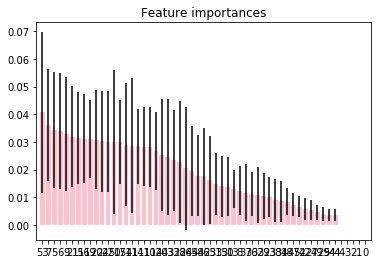

In [56]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="pink", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Waterfall

Later

# Predictions

Final Model

In [66]:
m = RandomForestClassifier(n_estimators = 275, 
                               random_state = 2019,
                               n_jobs = -1,
                               oob_score = True,
                               criterion = 'entropy',
                               min_samples_leaf = 1,
                               max_features='log2')
m.fit(train_features, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=275, n_jobs=-1,
            oob_score=True, random_state=2019, verbose=0, warm_start=False)

In [64]:
test_features = prep_time_series_features(test_values)

In [67]:
preds = m.predict(test_features)

## Submission

In [71]:
!ls 'data'

sample_submission.csv  X_test.csv      X_train.csv	y_train.csv
train.csv	       X_test.csv.zip  X_train.csv.zip


In [72]:
submission = pd.read_csv('data/sample_submission.csv', index_col=0)

In [73]:
submission.head(2)

,surface
series_id,
0,concrete
1,concrete


In [74]:
submission['surface'] = preds

In [75]:
submission.head(10)

,surface
series_id,
0,hard_tiles_large_space
1,carpet
2,tiled
3,carpet
4,soft_pvc
5,concrete
6,concrete
7,concrete
8,wood


In [76]:
submission.to_csv('Help_Robots_Submission.csv')